In [1]:
%pip install dask[complete]
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Starting a Cluster and connecting the Client

In [2]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 12.24 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46781,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 12.24 GiB
Comm: tcp://127.0.0.1:35453,Total threads: 2
Dashboard: http://127.0.0.1:33021/status,Memory: 3.06 GiB
Nanny: tcp://127.0.0.1:40403,


In [ ]:
# client.close()
# cluster.close()

### Using Dask at a high level

**Dask.array**: A multidimensional array composed of many small NumPy arrays.

![dask-array](./img/array.png)

In [5]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [6]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

**Dask.DataFrame**: Similarly to a dask array, a Dask DataFrame is a logical connection of many Pandas DataFrames (ex: using many hard drives to connect different datasets)

![title](./img/dataframe.png)

We create a random timeseries of data with the following attributes: 
* It stores a record for every second in the month of January of the year 2000
* It splits that month by day, keeping each day as a partitioned dataframe
* Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB.

In [7]:
from dask import datasets
# import dask.dataframe as dd
ddf = datasets.timeseries()
ddf

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [8]:
ddf_agg = ddf.groupby("name").aggregate({"x": "sum", "y": "max"})
ddf_agg.compute()

,x,y
name,,
Alice,21.785840,0.999991
Bob,-135.324761,0.999994
Charlie,-72.734266,0.999996
Dan,273.439234,0.999967
Edith,143.376808,0.999987
Frank,143.125198,0.999972
George,-177.447785,0.999998
Hannah,-107.574143,0.999997
Ingrid,97.572960,0.999980


In [9]:
ddf_agg = ddf_agg.repartition(npartitions=1)
joined = ddf.merge(
    ddf_agg, left_on="name", right_index=True, suffixes=("_original", "_aggregated")
)
joined.head()

,id,name,x_original,y_original,x_aggregated,y_aggregated
timestamp,,,,,,
2000-01-01 00:00:00,1026,Hannah,0.576478,0.752410,-107.574143,0.999997
2000-01-01 00:00:31,994,Hannah,-0.728126,0.797764,-107.574143,0.999997
2000-01-01 00:01:20,1048,Hannah,0.358420,0.287122,-107.574143,0.999997
2000-01-01 00:02:10,1018,Hannah,0.147003,0.307008,-107.574143,0.999997
2000-01-01 00:02:14,982,Hannah,-0.841280,-0.840567,-107.574143,0.999997


### The Delayed object & DAG

In [10]:
print(ddf.shape[0])

Delayed('int-79d10076-a245-4464-93f7-fb83c1c0a9a3')


In [11]:
print(ddf.shape[0].compute())

2592000


In [12]:
df = ddf.compute()
print(df.shape)
df

(2592000, 4)


,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,1026,Hannah,0.576478,0.752410
2000-01-01 00:00:01,1001,Yvonne,0.119709,-0.516878
2000-01-01 00:00:02,982,Norbert,-0.564482,-0.639522
2000-01-01 00:00:03,957,Charlie,0.047094,-0.206278
2000-01-01 00:00:04,961,Frank,0.152582,-0.491611
...,...,...,...,...
2000-01-30 23:59:55,1009,Zelda,0.408959,-0.703701
2000-01-30 23:59:56,980,Frank,-0.977333,-0.014253
2000-01-30 23:59:57,1002,Hannah,0.471347,-0.896350


By calling methods on **Delayed** objects, you are constructing a **Directed Acyclic (Computation) Graph** that will then be computed by Dask.

In [13]:
import dask
one = dask.delayed(1, name="one")
two = dask.delayed(2, name="two")

dsum = dask.delayed(sum, name="dsum")
three = dsum([one, two])
three.compute()

3

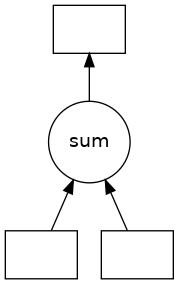

In [14]:
three.visualize()

The rectangular shapes represent data, while the circles represent operations. 

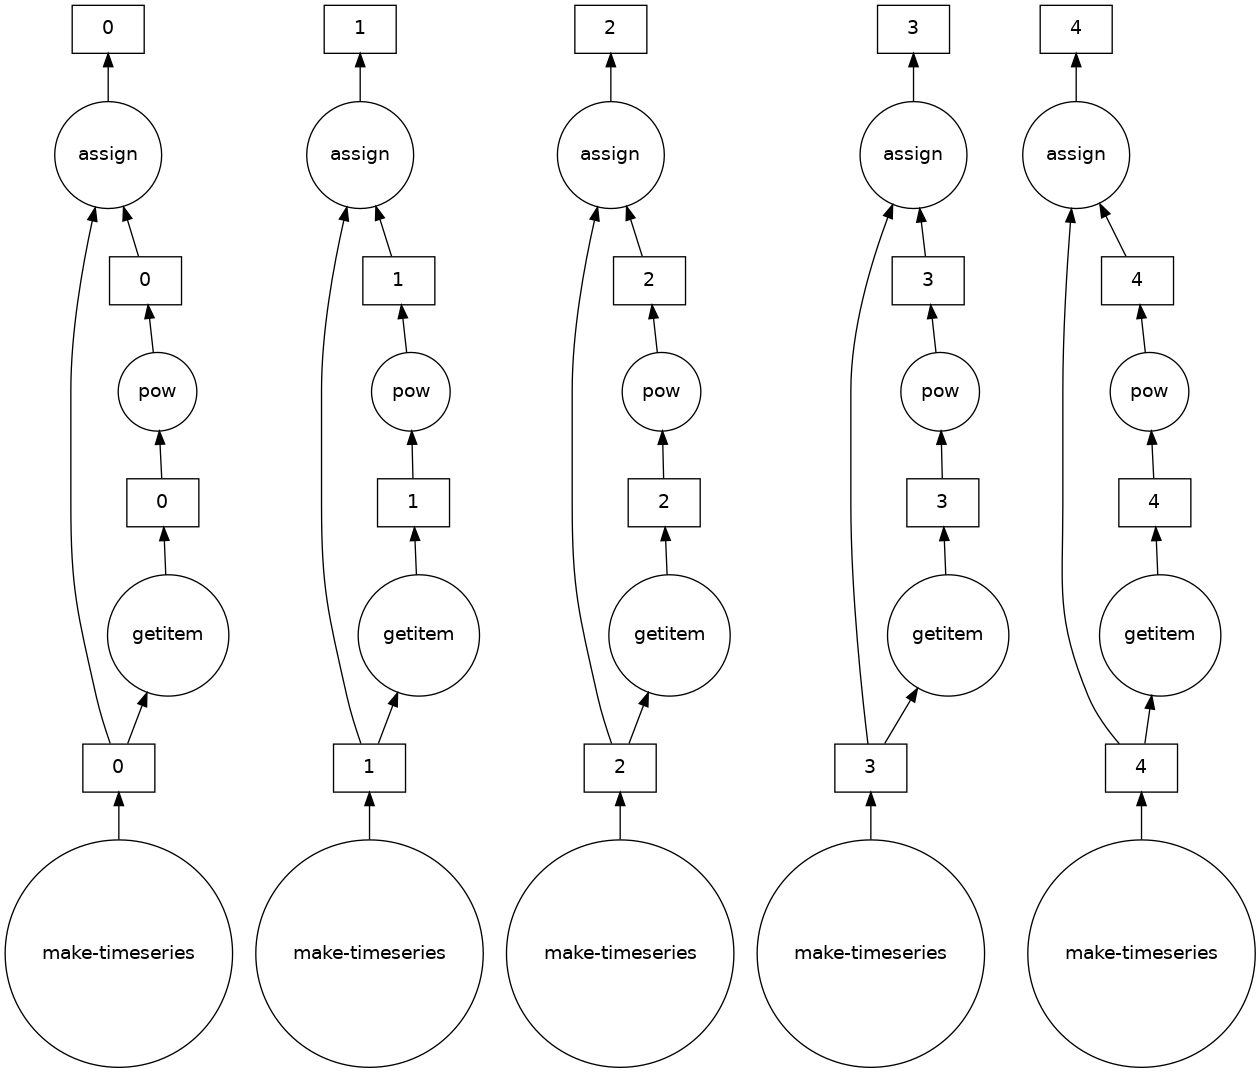

In [15]:
ddf1 = dask.datasets.timeseries(start="2000-01-01", end="2000-01-31", partition_freq="6d")
ddf1 = ddf1.assign(x_pow=ddf1.x**2)
ddf1.visualize()

In [16]:
ddf1.dask

HighLevelGraph with 4 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fb960c99ac0>
 0. make-timeseries-e3c3df9086cd18a37647719b3f5fe491
 1. getitem-bb7483eade74c6f50270e54fa650570c
 2. pow-ac56f62e916bd1d6eaf34263e6f7bb08
 3. assign-f9b1cc6396f461fbd6b750b0f4ad841d

We have:
1. **make-timeseries**: This is a Dask function that generates a partition of our timeseries dataframe.
2. **0,...,4**: These represent our Pandas dataframe partitions.
3. Now we have two edges. Let's follow the right path as the left one has no operations:
4. **getitem**: We get the column x from our dataframe;
5. **0,...,4**: This represents a pd.Series of our column;
6. **pow**: This is taking the series to the power of two;
7. **0,...,4**: Data representing our series taken by the power of two.
8. Now we’re at a mergepoint. We combine the result from the previous node with the result of step 2, using an assign operation. This assigns our series to the dataframe created by step 1.
9. **0,...,4**: The partitions of our end result.

In [17]:
ddf1.compute()

,id,name,x,y,x_pow
timestamp,,,,,
2000-01-01 00:00:00,1026,Yvonne,0.512098,0.524886,0.262244
2000-01-01 00:00:01,981,Oliver,-0.497092,-0.766097,0.247101
2000-01-01 00:00:02,965,George,-0.166223,0.373913,0.027630
2000-01-01 00:00:03,972,Oliver,-0.159604,0.626036,0.025474
2000-01-01 00:00:04,1035,Laura,0.165076,0.937508,0.027250
...,...,...,...,...,...
2000-01-30 23:59:55,976,Michael,0.278091,0.641960,0.077335
2000-01-30 23:59:56,1023,Sarah,-0.046496,-0.052112,0.002162
2000-01-30 23:59:57,952,Ingrid,-0.424262,-0.805956,0.179999


2022-05-20 11:30:00,993 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:00,995 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,035 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,049 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,069 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,072 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,097 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,164 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,166 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,181 - distributed.nanny - WARNING - Restarting worker
2022-05-20 11:30:01,217 - distributed.nanny - WARNING - Restarting worker
